In [13]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

from pymc3.step_methods.arraystep import BlockedStep

array([-1.10333845, -0.72502464, -0.78180526,  0.26697586, -0.24858073])

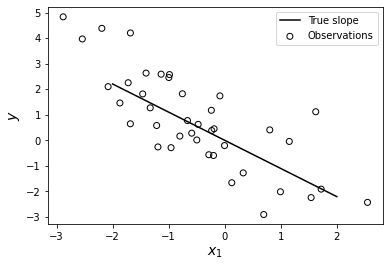

In [15]:
# ### Create simulated data under linear regression model


rng = np.random.default_rng(10)
n = 40
p = 5
sigma = 0.5

beta = rng.standard_normal(p)
X    = rng.standard_normal([n,p])
eps  = rng.standard_normal(n) * sigma

y = X@beta + eps

plt.scatter(X[:,0], y, color='k', facecolor='none', label='Observations')

domain = np.linspace(-2,2)
plt.plot(domain, beta[0]*domain, color='k', label='True slope')
plt.ylabel('$y$', fontsize=14), plt.xlabel('$x_1$', fontsize=14)
plt.legend();

display(beta)


In [17]:
np.shape(y)

(40,)

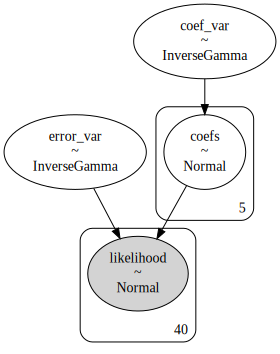

In [19]:
# ### Define multiple regression model
with pm.Model() as model:
    coef_var   = pm.InverseGamma('coef_var', alpha=1, beta=1)
    coefs      = pm.Normal('coefs', sd=coef_var**0.5, shape=p)
    error_var  = pm.InverseGamma('error_var', alpha=1, beta=1)
    likelihood = pm.Normal('likelihood', mu=X@coefs, sigma=error_var**0.5, observed=y)

pm.model_to_graphviz(model)   

In [21]:
with model:
    trace = pm.sample(return_inferencedata=True)
    
az.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error_var, coefs, coef_var]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[0],-1.094,0.058,-1.209,-0.993,0.001,0.001,4450.0,3378.0,1.0
coefs[1],-0.753,0.078,-0.902,-0.606,0.001,0.001,4094.0,2951.0,1.0
coefs[2],-0.925,0.085,-1.082,-0.761,0.001,0.001,4064.0,2803.0,1.0
coefs[3],0.239,0.093,0.070,0.415,0.001,0.001,4225.0,2946.0,1.0
coefs[4],-0.115,0.091,-0.285,0.050,0.001,0.001,3833.0,3296.0,1.0
coef_var,0.935,0.739,0.224,1.986,0.014,0.010,3968.0,2600.0,1.0
error_var,0.217,0.054,0.131,0.319,0.001,0.001,4049.0,3100.0,1.0


In [23]:
def undo_transform(point):
    '''
    Automatically transforms variables which were sampled on log
    scale back into original scale for convenience.
    '''
    transform_marker = '_log__'
    varnames = list(point.keys())
    for varname in varnames:
        if transform_marker in varname:
            new_key = varname.split(transform_marker)[0]
            point[new_key] = np.exp(point[varname])
            
    return point

In [25]:
X.T@X

array([[69.75700279,  8.10659623,  3.20607308,  2.03138637, 15.66432795],
       [ 8.10659623, 41.32252064, -2.00756822,  4.80027368, 12.44273176],
       [ 3.20607308, -2.00756822, 29.67125425, -0.54499573,  3.03585201],
       [ 2.03138637,  4.80027368, -0.54499573, 27.98738458,  9.5042951 ],
       [15.66432795, 12.44273176,  3.03585201,  9.5042951 , 33.4396835 ]])

In [27]:
class ConjugateStep(BlockedStep):
    '''
    Uses closed-form conditional distribution for linear regression
    coefficients given prior and error variances.
    '''
    def __init__(self, coefs, X, y, rng=None):
        self.vars=[coefs]
        self.X = X
        self.y = y
        self.p = X.shape[0]
        
        if rng:
            self.rng = rng
        else:
            self.rng = np.random.default_rng()
        
    def step(self, point: dict):
        point = undo_transform(point)
        prior_prec = point['coef_var']**-1
        XTX = X.T@X
        beta_hat = np.linalg.inv(XTX)@X.T@y
        prec_new_unscaled = (X.T @ X + prior_prec)
        cov_new = np.linalg.inv(prec_new_unscaled)* point['error_var']
        mu_new  =  prec_new_unscaled @ beta_hat
        point['coefs'] = self.rng.multivariate_normal(mu_new, cov_new)
        return point

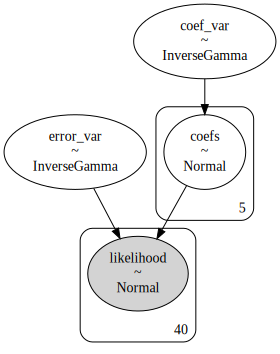

In [29]:
with pm.Model() as model:
    coef_var   = pm.InverseGamma('coef_var', alpha=1, beta=1)
    coefs      = pm.Normal('coefs', sd=coef_var**0.5, shape=p)
    error_var  = pm.InverseGamma('error_var', alpha=1, beta=1)
    likelihood = pm.Normal('likelihood', mu=X@coefs, sigma=error_var**0.5, observed=y)

    step = ConjugateStep(coefs, X, y, rng)

pm.model_to_graphviz(model)



In [30]:
with model:
    trace = pm.sample(step=step, chains=2, cores=1,return_inferencedata=True)
az.summary(trace)

Sequential sampling (2 chains in 1 job)
CompoundStep
>ConjugateStep: [coefs]
>NUTS: [error_var, coef_var]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[0],-86.748,19.412,-121.828,-49.662,0.452,0.325,1820.0,1818.0,1.00
coefs[1],-39.346,25.099,-83.951,11.099,0.585,0.431,1836.0,1926.0,1.01
coefs[2],-30.823,29.076,-83.848,23.927,0.691,0.534,1822.0,1665.0,1.00
coefs[3],-0.174,31.125,-63.854,54.654,0.716,0.574,1890.0,1758.0,1.00
coefs[4],-29.990,29.979,-89.257,25.838,0.717,0.507,1721.0,1816.0,1.00
coef_var,3231.092,3841.084,327.282,7829.054,256.901,191.082,337.0,332.0,1.01
error_var,23615.887,10944.561,2845.227,41799.507,621.997,440.233,223.0,41.0,1.01
